In [2]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from preprocessing import get_features_and_target
import matplotlib.pyplot as plt

In [58]:
df = get_features_and_target("BTC/USDT", day_to_forecast=1, feature_lags=[3, 9, 16, 24])

X = df.drop(columns=f"BTC:USDT_target")
y = df[f"BTC:USDT_target"].copy()

/var/folders/cd/xc6lw60d5711s9k_4hjp_dwc0000gn/T/ipykernel_7141/3899185866.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  above_05_both.rename(columns={"index": "Feature"}, inplace=True)


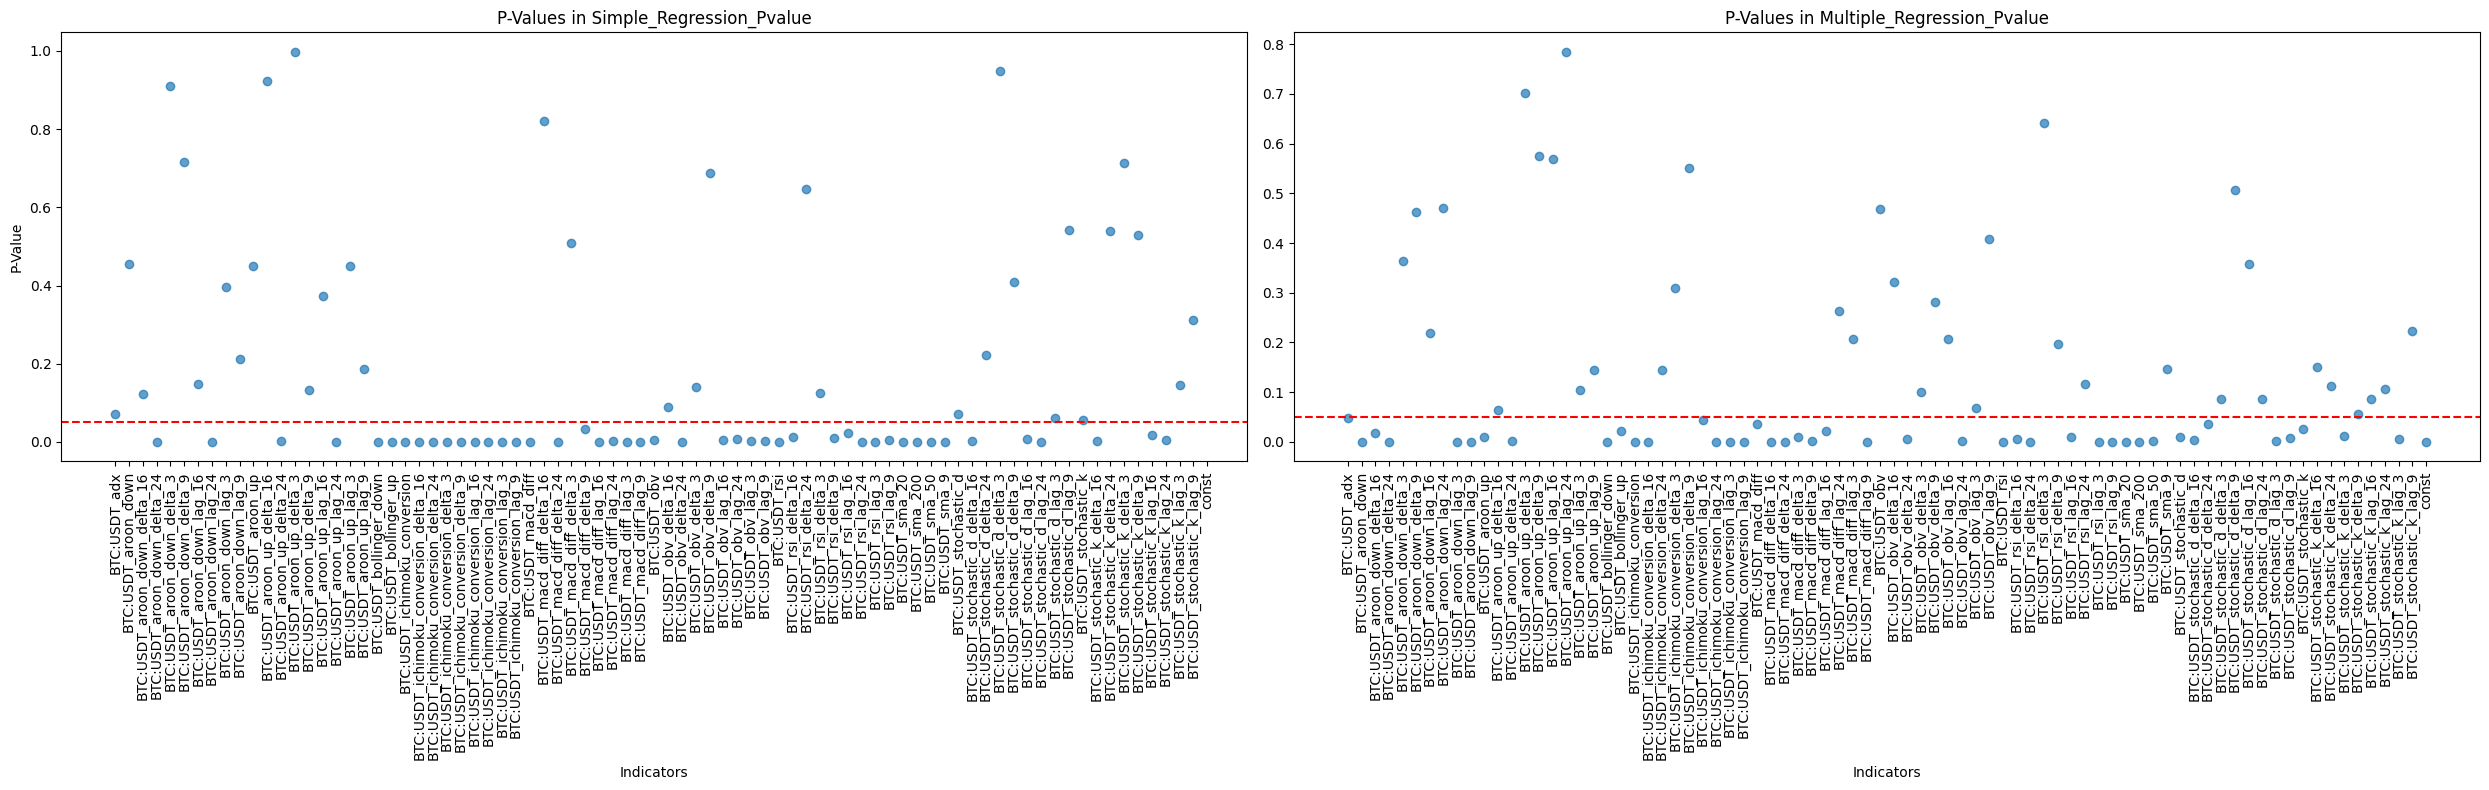

Indicators with p-values above 0.05 in both methods:


,Feature,Simple_Regression_Pvalue,Multiple_Regression_Pvalue
0,BTC:USDT_aroon_down_delta_3,0.910646,0.364652
1,BTC:USDT_aroon_down_delta_9,0.715290,0.461622
2,BTC:USDT_aroon_down_lag_16,0.147931,0.218820
3,BTC:USDT_aroon_up_delta_16,0.924317,0.063418
4,BTC:USDT_aroon_up_delta_3,0.997651,0.702584
5,BTC:USDT_aroon_up_delta_9,0.134059,0.574250
6,BTC:USDT_aroon_up_lag_16,0.374199,0.569882
7,BTC:USDT_aroon_up_lag_3,0.449514,0.104266
8,BTC:USDT_aroon_up_lag_9,0.187718,0.144701
9,BTC:USDT_obv_delta_16,0.088672,0.320668


In [59]:
# Assuming X and y are already defined
# Adding a constant for the intercept in the multiple linear regression
X_with_const = sm.add_constant(X)
model_multiple = sm.OLS(y, X_with_const).fit()

# Extract p-values from the Multiple_Regression_Pvalue model
p_values_multiple = model_multiple.pvalues

# Dictionary to store p-values from simple linear regressions
p_values_simple = {}

# Compute p-values using simple linear regressions
for indicator in X.columns:
    # Prepare the data
    X_indicator = X[[indicator]]  # Keep it as a DataFrame
    X_with_const = sm.add_constant(X_indicator)  # Adding a constant for intercept

    # Fit the linear regression model
    model_simple = sm.OLS(y, X_with_const).fit()

    # Get the p-value for the indicator
    p_value = model_simple.pvalues[indicator]
    p_values_simple[indicator] = p_value

# Convert to DataFrame for easier handling
df_p_values = pd.DataFrame(
    {
        "Simple_Regression_Pvalue": pd.Series(p_values_simple),
        "Multiple_Regression_Pvalue": pd.Series(p_values_multiple),
    }
)
# Identify indicators with p-values above 0.05 in both methods
above_05_both = df_p_values[
    (df_p_values["Simple_Regression_Pvalue"] > 0.05)
    & (df_p_values["Multiple_Regression_Pvalue"] > 0.05)
]
above_05_both.reset_index(inplace=True)
above_05_both.rename(columns={"index": "Feature"}, inplace=True)


# Plotting the distribution of p-values
plt.figure(figsize=(25, 8))

# Plot for Simple_Regression_Pvalue
plt.subplot(1, 2, 1)
plt.scatter(df_p_values.index, df_p_values["Simple_Regression_Pvalue"], alpha=0.7)
plt.axhline(y=0.05, color="r", linestyle="--")
plt.xlabel("Indicators")
plt.ylabel("P-Value")
plt.title("P-Values in Simple_Regression_Pvalue")
plt.xticks(rotation=90)

# Plot for Multiple_Regression_Pvalue
plt.subplot(1, 2, 2)
plt.scatter(df_p_values.index, df_p_values["Multiple_Regression_Pvalue"], alpha=0.7)
plt.axhline(y=0.05, color="r", linestyle="--")
plt.xlabel("Indicators")
plt.title("P-Values in Multiple_Regression_Pvalue")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Outputting the indicators with p-values above 0.05 in both methods
print("Indicators with p-values above 0.05 in both methods:")
above_05_both

In [11]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(X, y)

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame(
    {"Feature": X.columns, "Importance": model.feature_importances_}
)

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

common_features = feature_importances[
    feature_importances["Feature"].isin(above_05_both["Feature"])
]
common_features


,Feature,Importance
57,BTC:USDT_obv_delta_16,0.014344
41,BTC:USDT_obv_delta_9,0.009315
61,BTC:USDT_aroon_up_delta_16,0.006839
25,BTC:USDT_obv_delta_3,0.006705
35,BTC:USDT_stochastic_k_lag_9,0.006020
44,BTC:USDT_stochastic_d_delta_9,0.005710
28,BTC:USDT_stochastic_d_delta_3,0.005465
75,BTC:USDT_stochastic_k_delta_24,0.005457
43,BTC:USDT_stochastic_k_delta_9,0.005170
45,BTC:USDT_aroon_up_delta_9,0.005158


In [61]:
feature_importances.describe()

,Importance
count,79.000000
mean,0.012658
std,0.013146
min,0.002106
25%,0.005386
50%,0.007935
75%,0.015975
max,0.095349


In [60]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming X, y, and model are defined, and the model is trained
# X = X.drop(columns=common_features["Feature"].to_list())

# Select the last 100 observations from the feature set
X_last_100 = X.iloc[-100:]

# Predict using the model
preds_last_100 = model.predict(X_last_100)

# Actual last 100 values from the target variable
actual_last_100 = y.iloc[-100:]

# Calculate Mean Absolute Error and Mean Squared Error between actual and predicted values
mae = mean_absolute_error(actual_last_100, preds_last_100)
mse = mean_squared_error(actual_last_100, preds_last_100)

# Calculate R-squared value
r2 = r2_score(actual_last_100, preds_last_100)

print("Mean Absolute Error for the last 100 observations:", mae)
print("Mean Squared Error for the last 100 observations:", mse)
print("R-squared for the last 100 observations:", r2)

Mean Absolute Error for the last 100 observations: 0.002821462726917452
Mean Squared Error for the last 100 observations: 1.4527290379804249e-05
R-squared for the last 100 observations: 0.945171457845379


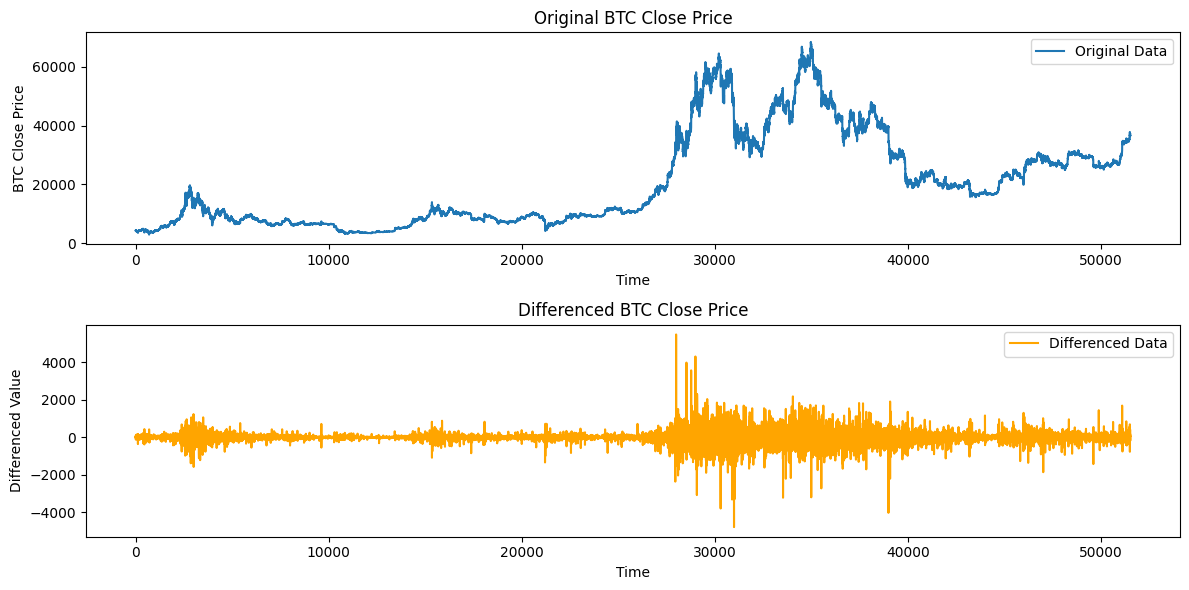

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your data
btc_data = pd.read_csv(
    "BTC:USDT_price_data.csv"
)  # Replace with the path to your CSV file
btc_close = btc_data["BTC:USDT_close"]

# Differencing the series
differenced_btc_close = btc_close.diff().dropna()

# Plotting
plt.figure(figsize=(12, 6))

# Original Data Plot
plt.subplot(2, 1, 1)
plt.plot(btc_close, label="Original Data")
plt.title("Original BTC Close Price")
plt.xlabel("Time")
plt.ylabel("BTC Close Price")
plt.legend()

# Differenced Data Plot
plt.subplot(2, 1, 2)
plt.plot(differenced_btc_close, label="Differenced Data", color="orange")
plt.title("Differenced BTC Close Price")
plt.xlabel("Time")
plt.ylabel("Differenced Value")
plt.legend()

plt.tight_layout()
plt.show()

When using an ARIMA model to make predictions, particularly on differenced data like your Bitcoin closing prices, the model first fits to the differenced data and then integrates the predictions back to the original scale to produce actual forecasted values. Here's a step-by-step overview of how this process works:

1. **Model Fitting**:
   - The ARIMA model is fitted to the differenced data. This is because ARIMA, particularly the 'I' (Integrated) part, is designed to model data that has been made stationary through differencing.
   - During the fitting process, the ARIMA model estimates the parameters for the autoregressive (AR) and moving average (MA) components based on the order you specify (parameters p, d, q).

2. **Forecasting on Differenced Data**:
   - Once the model is fitted, it can be used to make forecasts on the differenced data. These forecasts represent predictions of the differences in values, not the actual values themselves.

3. **Reverting Differencing (Integration)**:
   - To convert the differenced forecasts back to the original scale, an integration process is applied, which essentially undoes the differencing.
   - This is done by adding the forecasted differences to the last actual observed value (or values, in case of higher-order differencing) of the non-differenced time series.
   - For first-order differencing, the process is relatively straightforward: add the predicted difference to the last actual value to get the first forecast, then add the next predicted difference to this forecasted value, and so on.

4. **Producing Actual Values**:
   - The result of this integration process is a series of forecasted values on the same scale as the original time series data. These are the actual values you're interested in.

5. **Example in Python**:
   Here's a simplified example using the `statsmodels` library in Python:
   ```python
   from statsmodels.tsa.arima.model import ARIMA

   # Assuming btc_close is your original time series
   model = ARIMA(btc_close, order=(p, d, q))  # p, d, q are ARIMA parameters
   fitted_model = model.fit()

   # Forecasting future values
   forecasted_diff = fitted_model.forecast(steps=n_steps)  # n_steps is the number of future steps you want to predict

   # Reverting differencing to get actual values
   last_value = btc_close.iloc[-1]
   forecasted_actual = last_value + forecasted_diff.cumsum()
   ```

In this process, the key is the correct application of differencing and integration to ensure that the forecasts are aligned with the original data scale. It's also important to choose the right ARIMA parameters (p, d, q) to fit the model appropriately to your data.

ARIMAX does same but with additional features, so better to use it for testing